# 07. Math Tools #

In [1]:
import QuantLib as ql
today = ql.Date(15,6,2020)
ql.Settings.instance().evaluationDate = today

## Solvers ##

In [2]:
mySolv = ql.Brent()

In [3]:
ql.Settings.instance().evaluationDate = ql.Date(15,6,2020)
crv = ql.FlatForward(2, ql.TARGET(), 0.05, ql.Actual360())
yts = ql.YieldTermStructureHandle(crv)
engine = ql.DiscountingSwapEngine(yts)

schedule = ql.MakeSchedule(ql.Date(15,9,2020), ql.Date(15,9,2021), ql.Period('6M'))
index = ql.Euribor3M(yts)
floatingLeg = ql.IborLeg([100], schedule, index)

def swapFairRate(rate):
    fixedLeg = ql.FixedRateLeg(schedule, ql.Actual360(), [100.], [rate])
    swap = ql.Swap(fixedLeg, floatingLeg)
    swap.setPricingEngine(engine)
    return swap.NPV()

solver = ql.Brent()

accuracy = 1e-5
guess = 0.0
step = 0.001
solver.solve(swapFairRate, accuracy, guess, step)

0.050639044891605485

## Integration ##

In [4]:
import numpy as np

f = lambda x: x**2
g = lambda x: np.exp(x)

quad_ql_legendre = ql.GaussLegendreIntegration(128)
quad_ql_legendre(f), quad_ql_legendre(g)

(0.6666666666666666, 2.3504023872876028)

In [5]:
from scipy.integrate import quad
quad(f, -1, 1)[0], quad(g, -1, 1)[0]

(0.6666666666666666, 2.3504023872876028)

In [6]:
def quad_ql_ab(f, a, b, quad):
    multiplier, ratio = (b+a) / 2, (b-a) / 2
    y = lambda x: f(ratio*x + multiplier)
    return quad(y) * ratio

quad_ql = ql.GaussLegendreIntegration(128)
quad_ql_ab(f, -2, 2, quad_ql), quad_ql_ab(g, -2, 2, quad_ql), quad(f, -2, 2)[0], quad(g, -2, 2)[0]

(5.333333333333333, 7.2537208156940425, 5.333333333333333, 7.253720815694037)

## Interpolation ##

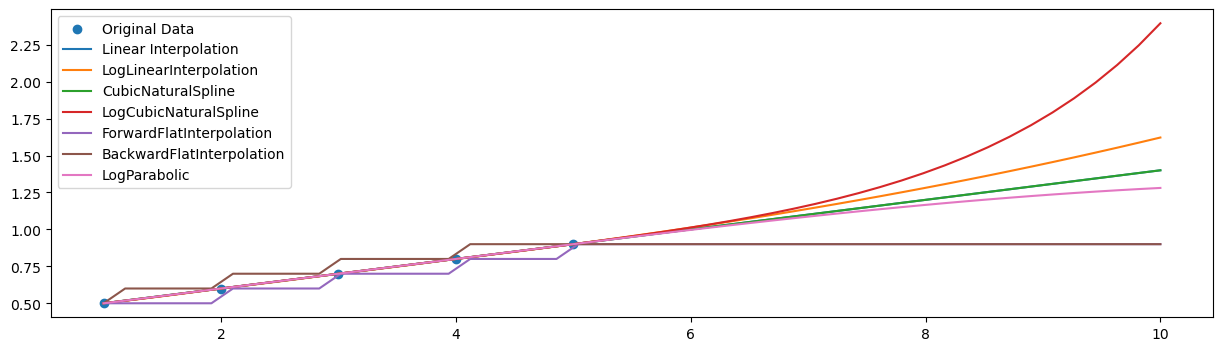

In [7]:
import numpy as np
import matplotlib.pyplot as plt

X = [1., 2., 3., 4., 5.]
Y = [0.5, 0.6, 0.7, 0.8, 0.9]

methods = {
    'Linear Interpolation': ql.LinearInterpolation(X, Y),
    'LogLinearInterpolation': ql.LogLinearInterpolation(X, Y),
    'CubicNaturalSpline': ql.CubicNaturalSpline(X, Y),
    'LogCubicNaturalSpline': ql.LogCubicNaturalSpline(X, Y),
    'ForwardFlatInterpolation': ql.ForwardFlatInterpolation(X, Y),
    'BackwardFlatInterpolation': ql.BackwardFlatInterpolation(X, Y),
    'LogParabolic': ql.LogParabolic(X, Y)
}

xx = np.linspace(1, 10)
fig = plt.figure(figsize=(15,4))
plt.scatter(X, Y, label='Original Data')
for name, i in methods.items():
    yy = [i(x, allowExtrapolation=True) for x in xx]
    plt.plot(xx, yy, label=name);
plt.legend();

In [12]:
import pandas as pd
X = [1., 2., 3., 4., 5.]
Y = [0.6, 0.7, 0.8, 0.9]
Z = [[(x-3)**2 + y for x in X] for y in Y]
df = pd.DataFrame(Z, columns=X, index=Y)

i = ql.BilinearInterpolation(X, Y, Z)

XX = np.linspace(0, 5, 9)
YY = np.linspace(0.55, 1.0, 10)

extrapolated = pd.DataFrame(
    [[i(x,y, True) for x in XX] for y in YY],
    columns=XX,
    index=YY)


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax.set_title("Surface Interpolation")

Xs, Ys = np.meshgrid(XX, YY)
#surf = ax.plot_surface(
#    Xs, Ys, extrapolated, rstride=1, cstride=1, cmap=cm.coolwarm
#)
#fig.colorbar(surf, shrink=0.5, aspect=5);

<Figure size 640x480 with 0 Axes>

## Optimization ##

## Random Number Generators ##

In [14]:
#r = rng.next()
#v = r.value(r)

In [15]:
seed = 12324
unifMt = ql.MersenneTwisterUniformRng(seed)
bmGauss = ql.BoxMullerMersenneTwisterGaussianRng(unifMt)

for i in range(5):
    print(bmGauss.next().value())

-1.1756781173398896
0.14110041851886157
1.569582906805544
-0.026736779238941934
-0.8220676600472409


## Path Generators ##

In [16]:
timestep, length, numPaths = 24, 2, 2**15

today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.01, ql.Actual365Fixed()))
initialValue = ql.QuoteHandle(ql.SimpleQuote(100))

v0, kappa, theta, rho, sigma = 0.005, 0.8, 0.008, 0.2, 0.1
hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)

times = ql.TimeGrid(length, timestep)
dimension = hestonProcess.factors()

rng = ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
pathGenerator = ql.GaussianMultiPathGenerator(hestonProcess, list(times), sequenceGenerator, False)

# paths[0] will contain spot paths, paths[1] will contain vol paths
paths = [[] for i in range(dimension)]
for i in range(numPaths):
    samplePath = pathGenerator.next()
    values = samplePath.value()
    spot = values[0]

    for j in range(dimension):
        paths[j].append([x for x in values[j]])

In [17]:
timestep, length, numPaths = 24, 2, 2**15

today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.01, ql.Actual365Fixed()))
initialValue = ql.QuoteHandle(ql.SimpleQuote(100))

v0, kappa, theta, rho, sigma = 0.005, 0.8, 0.008, 0.2, 0.1
hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)

times = ql.TimeGrid(length, timestep)
dimension = hestonProcess.factors()

rng = ql.UniformLowDiscrepancySequenceGenerator(dimension * timestep)
sequenceGenerator = ql.GaussianLowDiscrepancySequenceGenerator(rng)
pathGenerator = ql.GaussianSobolMultiPathGenerator(hestonProcess, list(times), sequenceGenerator, False)

# paths[0] will contain spot paths, paths[1] will contain vol paths
paths = [[] for i in range(dimension)]
for i in range(numPaths):
    samplePath = pathGenerator.next()
    values = samplePath.value()
    spot = values[0]

    for j in range(dimension):
        paths[j].append([x for x in values[j]])

## Statistics ##

## Convention Calculators ##

In [18]:
import numpy as np

today = ql.Date().todaysDate()
dayCounter = ql.Actual365Fixed()
spot = 100
rd, rf = 0.02, 0.05

ratesTs = ql.YieldTermStructureHandle(ql.FlatForward(today, rd, dayCounter))
dividendTs = ql.YieldTermStructureHandle(ql.FlatForward(today, rf, dayCounter))

# Details about the delta quote
optionType = ql.Option.Put
vol = 0.07
maturity = 1.0
deltaType = ql.DeltaVolQuote.Fwd      # Also supports: Spot, PaSpot, PaFwd

# Set up the calculator
localDcf, foreignDcf = ratesTs.discount(maturity), dividendTs.discount(maturity)
stdDev = np.sqrt(maturity) * vol
calc = ql.BlackDeltaCalculator(optionType, deltaType, spot, localDcf, foreignDcf, stdDev)

In [19]:
delta = -0.3
calc.strikeFromDelta(delta)

93.77629917634447

In [20]:
atmType = ql.DeltaVolQuote.AtmFwd     # Also supports: AtmSpot, AtmDeltaNeutral, AtmVegaMax, AtmGammaMax, AtmPutCall50
calc.atmStrike(atmType)

97.0445533548508